# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from datetime import datetime

# SKlearn 
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,accuracy_score
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

import os
import sys

# Define directories separation character based on OS
# Values were found in https://stackoverflow.com/a/13874620
# Darwin - MacOS
if sys.platform in ['darwin', 'linux']: 
    dir_sep = '/'

# Windows, Windows/cygwin, Windows/MSYS2
elif sys.platform in ['win32', 'msys', 'cygwin']: 
    dir_sep = '\\'

# Read Incidents Dataset - Capstone I 
incidents = pd.read_csv(f"..{dir_sep}data{dir_sep}Aggregated{dir_sep}incidents.csv")

# Read clusters data
cluster_Map = pd.read_csv(f"..{dir_sep}data{dir_sep}Aggregated{dir_sep}cluster_mapping.csv")

# Pre-processing

## Multi-drug use

In [2]:
incidents['Multiple Drugs'] = 0
incidents.loc[incidents['All Drugs'].str.contains(' | ', regex = False), 'Multiple Drugs'] = 1
incidents[incidents['Multiple Drugs'] == 1].shape

(8050, 17)

## Fentanyl

In [3]:
incidents['Fentanyl'] = 0
incidents.loc[incidents['All Drugs'].str.contains('FENTANYL', regex = False), 'Fentanyl'] = 1
incidents['Fentanyl'].value_counts()

0    13342
1     7255
Name: Fentanyl, dtype: int64

## Year, Month and Age Range

In [4]:
def agerange_weekend(df):
    
    df_cpy = df.copy()
    for i, row in df_cpy.iterrows():
        
        # Weekend Binary Feature
        if row['Day'] in ['Friday', "Saturday", "Sunday"]:
            df_cpy.loc[i,'Weekend_OD'] = 1
        else:
            df_cpy.loc[i,'Weekend_OD'] = 0
        
        # Season Features - Winter, Spring, Summer and Fall
        if row['month'] in [1, 12, 2]:
            df_cpy.loc[i,'Season'] = 'Winter'
            
        elif row['month'] in [3,4, 5]:
            df_cpy.loc[i,'Season'] = 'Spring'
            
        elif row['month'] in [6, 7, 8]:
            df_cpy.loc[i,'Season'] = 'Summer'
            
        elif row['month'] in [9, 10, 11]:
            df_cpy.loc[i,'Season'] = 'Fall' 
        
        # Age Binary feature - over/below 40 years old
        if row['Age Range'] in ['0 - 9', '10 - 14', '15 - 19', '20 - 24','25 - 29', '30 - 39']:
            df_cpy.loc[i,'Over 40'] = 0
        else:    
            df_cpy.loc[i,'Over 40'] = 1
        
    # Ensure dtype for binary features is int
    df_cpy['Over 40'] = df_cpy['Over 40'].astype(int)
    df_cpy['Weekend_OD'] = df_cpy['Weekend_OD'].astype(int)
        
    return df_cpy

# Philadelphia indicator (binary)
def isphila(df):
    for i, row in df.iterrows():
        if row['Incident County Name'] == 'Philadelphia':
            df.loc[i,'Phila'] = 1
        else:
            df.loc[i,'Phila'] = 0
    return (df) 

# Philadelphia indicator (binary)
def isluzerne(df):
    for i, row in df.iterrows():
        if row['Incident County Name'] == 'Luzerne':
            df.loc[i,'Luzerne'] = 1
        else:
            df.loc[i,'Luzerne'] = 0
    return (df)

## Pre-processing

In [5]:
# Covert date into year and month
incidents["year"] = incidents['Incident Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').year)
incidents["month"] = incidents['Incident Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').month)

# Fix value typo
incidents["Age Range"] = incidents["Age Range"].apply(lambda x: "10 - 14" if x == "14-Oct" else x)

# Convert age range to over 40 (binary), month to season (Categorical), and day to weekend (binary)
incidents2 = agerange_weekend(incidents)

# Merge incidents with cluster
incidents3 = pd.merge(incidents2,cluster_Map, how="inner",left_on = 'Incident County Name',right_on = 'County')
incidents3['Cluster'] = incidents3['Cluster'].astype(str)

# Added philadelphia binary indicator
incidents3 = isphila(incidents3.copy())
incidents3['Phila'] = incidents3['Phila'].astype(int)

## Final Features

In [6]:
#### Good
# Define features and target
X = incidents3[['Over 40','Naloxone Administered','Fentanyl','Multiple Drugs', "Phila"]]
y = incidents3[['Survive']]

# # Class weights are required because of class imbalance issue
# class_weight_m = dict(y['Survive'].value_counts())
# class_weight_m

## Pipeline Definition

In [7]:
##pipeline  NOT GOOD

#label_features =['Cluster']
#label_transformer = OneHotEncoder(sparse = False, handle_unknown = 'ignore')



#preprocessor = ColumnTransformer(
 #   transformers=[
  #      ('label', label_transformer, label_features)
   #     ])   


#rf_model =  Pipeline(steps=[('preprocessor', preprocessor),
 #                     ('randomforest', RandomForestClassifier(n_estimators=1000,
  #                                                           class_weight=class_weight_m))])

In [8]:
#### Good

# Random Forest
rf_model =  Pipeline(steps=[
                      ('randomforest', RandomForestClassifier(n_estimators=1000,
                                                              class_weight="balanced"))])

# Logistic regression
lr_model = Pipeline(steps=[
                           ('logisticregression', LogisticRegression(class_weight="balanced"))])

# Decision Tree
dt_model =  Pipeline(steps=[
                           ('decisiontree',DecisionTreeClassifier(random_state = 42,
                                                                  class_weight="balanced"))])

## Split data

In [9]:
# Split data with stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

## Class Imbalance

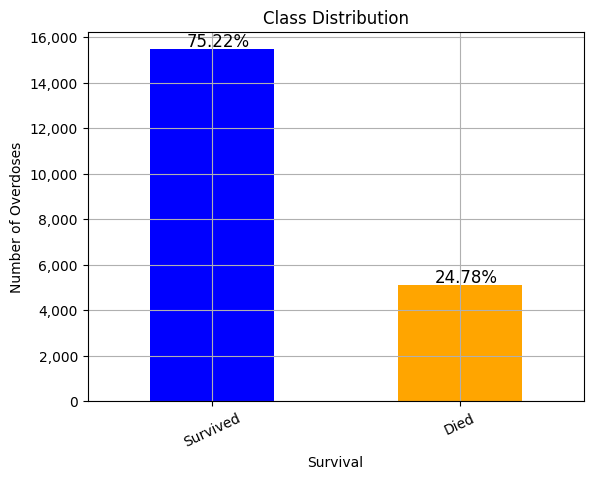

In [10]:
total_od = sum(y.value_counts())
ax = y.value_counts().plot(kind="bar",
                           rot = 25,
                           title = "Class Distribution",
                           ylabel = "Number of Overdoses",
                           xlabel = "Survival",
                           grid = True,
                           color = ["Blue", "Orange"])
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, _: format(int(x), ',')))
ax.set_xticklabels(["Survived", "Died"])

for patch in ax.patches:
    ax.annotate('{:.2f}%'.format(patch.get_height() / total_od * 100),                # Count
               (patch.get_x() + 0.15, patch.get_height()+150),          # x,y coordinates for label.
               fontsize=12)  

## Correlation heat map

<AxesSubplot: title={'center': 'Spearman Correlation'}>

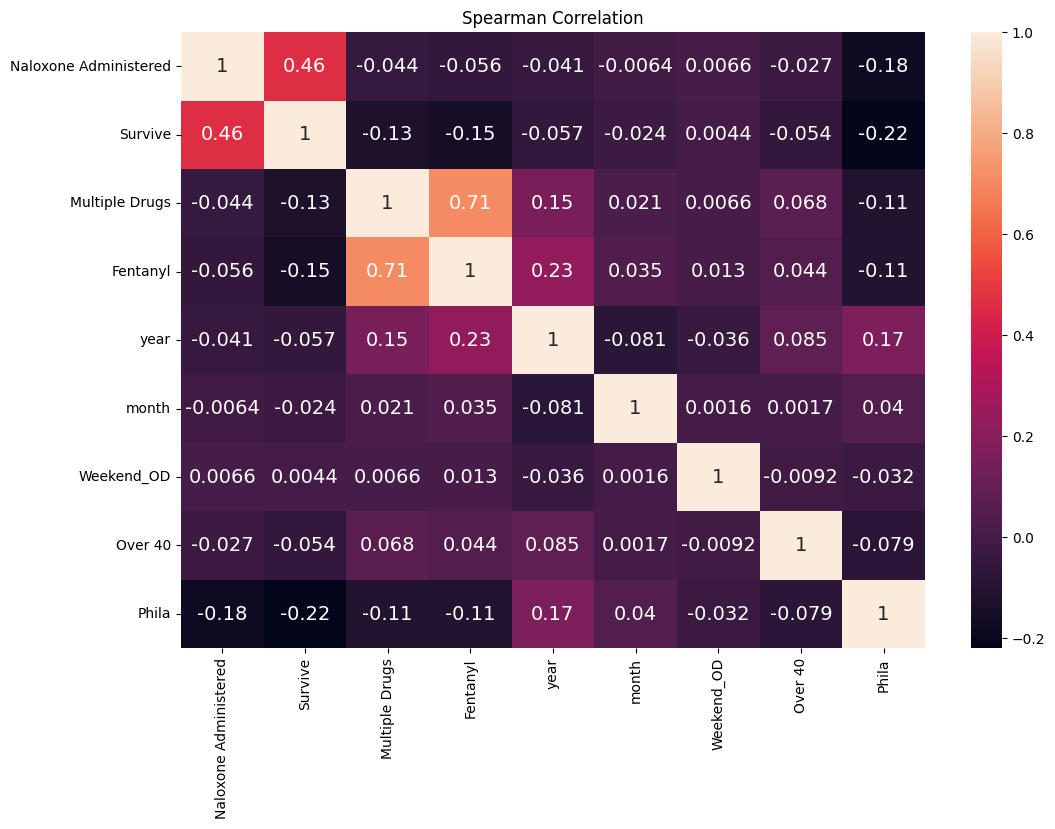

In [11]:
cor = incidents3.drop(['Incident ID', 'Victim ID', 'Incident Date ym', 'Unnamed: 0'], axis = 1).corr(method = "spearman")
plt.figure(figsize = (12,8))
plt.title("Spearman Correlation")
sns.heatmap(cor, annot = True, cmap = 'rocket',annot_kws={"fontsize":14})

## Baseline

Dummy classifier predict survived (1) when Naloxone was administered AND there were no multiple drugs. Otherwise died.

In [12]:
dummy_clf = X_train[["Naloxone Administered", 'Multiple Drugs']].apply(lambda x: 1 if x[0] == 1 and x[1] == 0 else 0, axis = 1)
print(classification_report(y_train, dummy_clf, target_names=["Died", "Survived"]))

print(matthews_corrcoef(y_train,dummy_clf))

              precision    recall  f1-score   support

        Died       0.36      0.84      0.51      3823
    Survived       0.91      0.52      0.66     11603

    accuracy                           0.59     15426
   macro avg       0.63      0.68      0.58     15426
weighted avg       0.77      0.59      0.62     15426

0.30698195777698684


## Fit Models

In [13]:
# Random Forest
rf_model.fit(X_train,y_train)

# Logistic Regression
lr_model.fit(X_train,y_train)

# Decision Tree
dt_model.fit(X_train,y_train)

Pipeline(steps=[('decisiontree',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

## Predict

In [14]:
# Random Forest 
predictions_classweights = rf_model.predict(X_test)
print("accuracy:",accuracy_score(y_test, predictions_classweights))

# Logistic Regression
LR_predictions_classweights = lr_model.predict(X_test)
print("accuracy:",accuracy_score(y_test, LR_predictions_classweights))

# Decision Tree
dt_predictions_classweights = dt_model.predict(X_test)
print("accuracy:",accuracy_score(y_test, dt_predictions_classweights))

accuracy: 0.7828115885669843
accuracy: 0.7775617343962667
accuracy: 0.7828115885669843


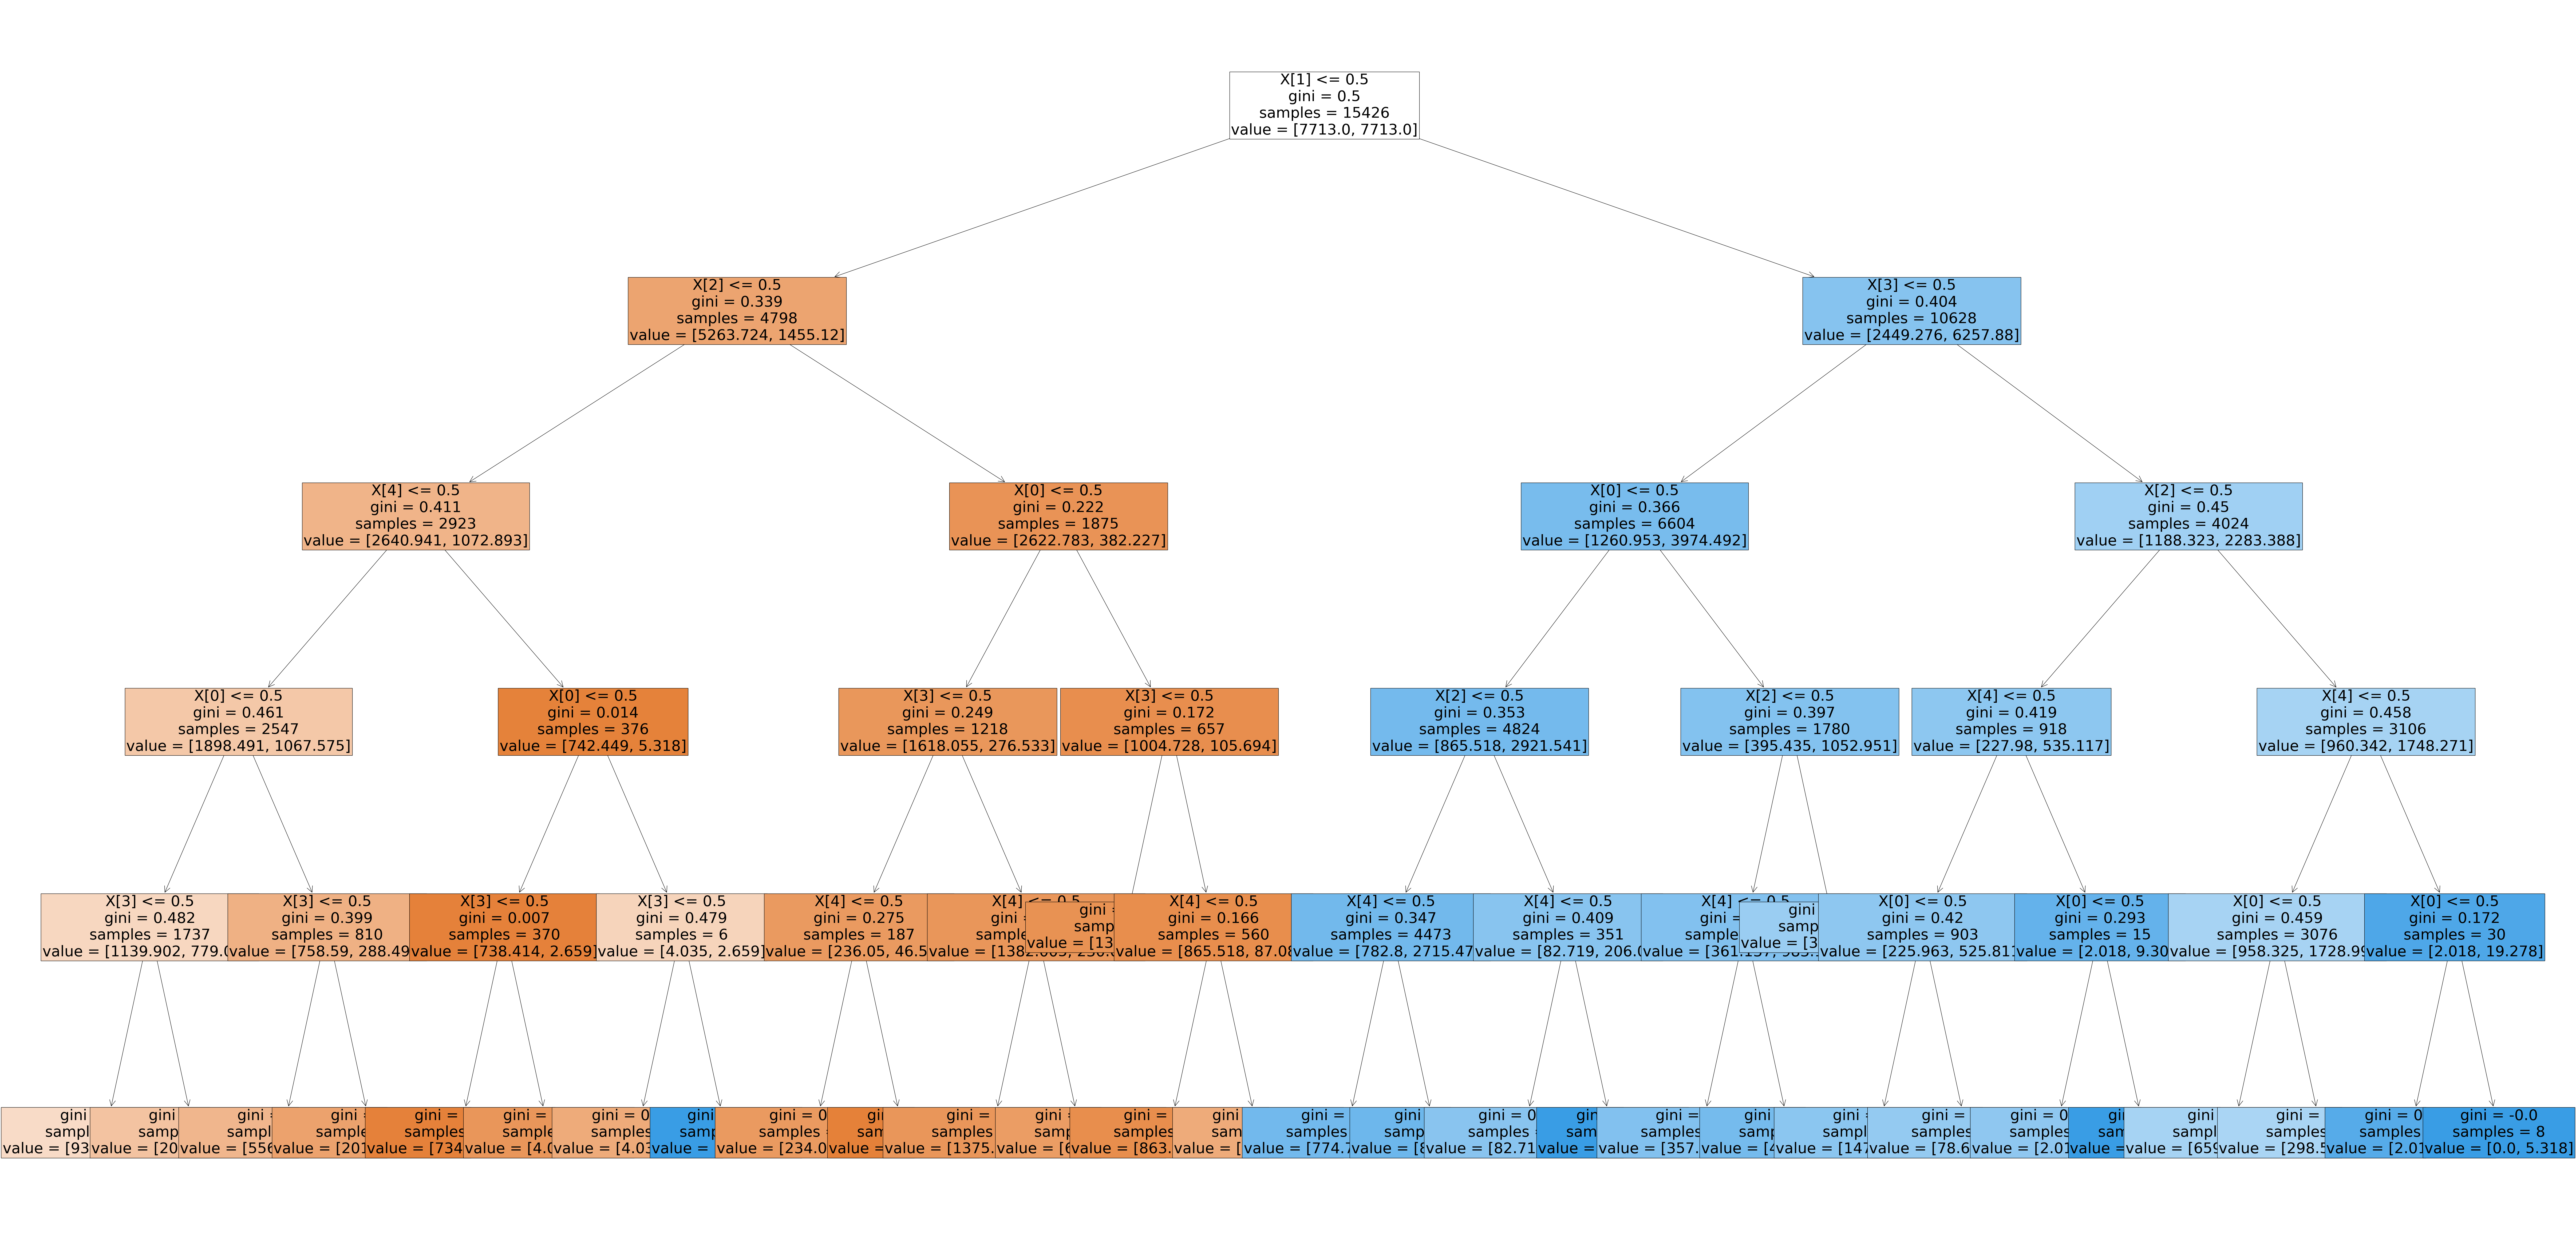

In [15]:
from sklearn import tree
plt.figure(figsize = (120, 60))
tree.plot_tree(dt_model.named_steps["decisiontree"], filled = True, fontsize=40)
plt.savefig('./tree.png')
plt.show()

# Cross Validation

In [16]:
def cross_validation(X, y, model, n_splits = 5,  **kwargs):
    
    # KFold object
    kf = StratifiedKFold(n_splits=n_splits,random_state=0, shuffle=True)
    
    # Empty lists
    acc_score = []
    pred = []
    y_test_all = []
    pred_prob = []
    
    # KFold iterations
    for i, (train_index, test_index) in enumerate(kf.split(X,y)):
        print(f"Run #{i}")
        
        # Train and test features and target
        X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        
        # Fit and score model
        model.fit(X_train,y_train)
        print(model.score(X_test, y_test))
        num = model.score(X_test, y_test)
        num = num.astype(float)
        acc_score.append(num)
        
        # Predict
        predictions_classweights = model.predict(X_test)
        proba = model.predict_proba(X_test)
        pred_prob.append(proba)                           
        
        # Store results
        pred.append(predictions_classweights)
        y_test_all.append(y_test)
        
        # Print ROC AUC results
        print(f"ROC AUC Score: {roc_auc_score(y_test,predictions_classweights)}", end = "\n")
        
        print(f"Matthews Correlation: {matthews_corrcoef(y_test,predictions_classweights)}", end = "\n\n")
        
    # Return lists
    return pred, y_test_all, pred_prob


In [17]:
rf_cross_pred, rf_cross_test, rf_cross_prob = cross_validation(X, y, rf_model)

Run #0
0.7783179387457463
ROC AUC Score: 0.744839474251239
Matthews Correlation: 0.45713044011637405

Run #1
0.7717549829849295
ROC AUC Score: 0.7424477483301013
Matthews Correlation: 0.44899764761270744

Run #2
0.7788040836169179
ROC AUC Score: 0.7466809140070487
Matthews Correlation: 0.4597266713746954

Run #3
0.7826932425862907
ROC AUC Score: 0.7525569906826833
Matthews Correlation: 0.4702779655768692

Run #4
0.7894480914174569
ROC AUC Score: 0.7577096891447754
Matthews Correlation: 0.48237399211172466



In [18]:
lr_cross_pred,lr_cross_test, lr_cross_prob = cross_validation(X, y, lr_model)

Run #0
0.7712688381137579
ROC AUC Score: 0.7417959491488904
Matthews Correlation: 0.4477905574207163

Run #1
0.764948954788527
ROC AUC Score: 0.7385800474035767
Matthews Correlation: 0.4390722392822169

Run #2
0.7751579970831308
ROC AUC Score: 0.7459032819086786
Matthews Correlation: 0.45589416534806426

Run #3
0.7756441419543024
ROC AUC Score: 0.7491885198989792
Matthews Correlation: 0.4604996990219699

Run #4
0.7828835399951374
ROC AUC Score: 0.753346405369727
Matthews Correlation: 0.47145657274063146



In [19]:
dt_cross_pred, dt_cross_test, dt_cross_prob= cross_validation(X, y, dt_model)

Run #0
0.7783179387457463
ROC AUC Score: 0.744839474251239
Matthews Correlation: 0.45713044011637405

Run #1
0.7719980554205154
ROC AUC Score: 0.7432665373841845
Matthews Correlation: 0.45024232775678186

Run #2
0.7788040836169179
ROC AUC Score: 0.7466809140070487
Matthews Correlation: 0.4597266713746954

Run #3
0.7826932425862907
ROC AUC Score: 0.752886116928599
Matthews Correlation: 0.47069189213758156

Run #4
0.7894480914174569
ROC AUC Score: 0.7577096891447754
Matthews Correlation: 0.48237399211172466



In [20]:
def change_threshold(pred_prob_all, 
                     y_test_all, 
                     threshold: int = .5,
                     log: bool = False):
    y_test_master = pd.concat(y_test_all)
    
    probs = [pd.DataFrame(a, columns = ['zero', 'one']) for a in pred_prob_all]
    probs_final = pd.concat(probs)
    probs_final = probs_final[['one']]
    
    probs_final['one'] = np.select([probs_final['one'] > threshold],  ### setting threshold
                                    [1],
                                    default=0)
    
    conf_matrix = confusion_matrix(y_test_master,probs_final)
    roc_score = roc_auc_score(y_test_master,probs_final)
    matthews_score = matthews_corrcoef(y_test_master,probs_final)
    target_names = ['Died', 'Survived']
    clf_report = classification_report(y_test_master, probs_final, target_names=target_names)
    if log:
        print("Confusion Matrix: ")
        print(conf_matrix, end = "\n\n")

         # Print ROC AUC results
        print(f"ROC AUC Score: {roc_score}", end = "\n")
        print(f"Matthews Correlation: {matthews_score}", end = "\n\n")

        
        print("Classification Report: ")
        print(clf_report)
    
    
    
    return conf_matrix, roc_score, matthews_score, clf_report, probs_final

def plot_threshold_scores(probs, test):
    thresholds_ls, matthews_score_ls, roc_score_ls = [], [], []

    for i  in range(20, 95, 5):
        threshold = i / 100
        thresholds_ls.append(threshold)
        _ = change_threshold(probs, test, threshold)
        matthews_score_ls.append(_[2])
        roc_score_ls.append(_[1])

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(thresholds_ls, matthews_score_ls , marker = "*", color = 'Orange', label='Matthew\'s Score')
    ax.plot(thresholds_ls, roc_score_ls, marker='.', color = 'Blue', label='AUC Score')
    ax.set_xlabel("Threshold", fontsize = 12)
    ax.set_ylabel("Score", fontsize = 12)
    ax.set_title("Threshold Scores")
    plt.rcParams.update({"font.size": 12})
    plt.legend()

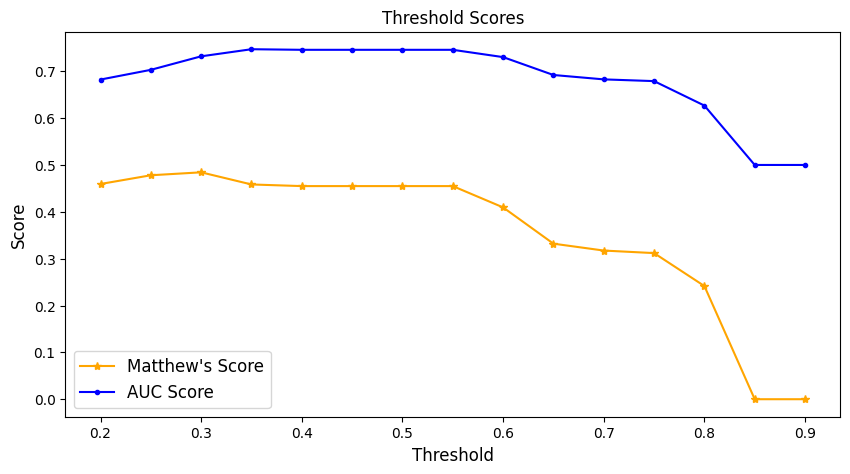

In [21]:
plot_threshold_scores(lr_cross_prob, lr_cross_test)

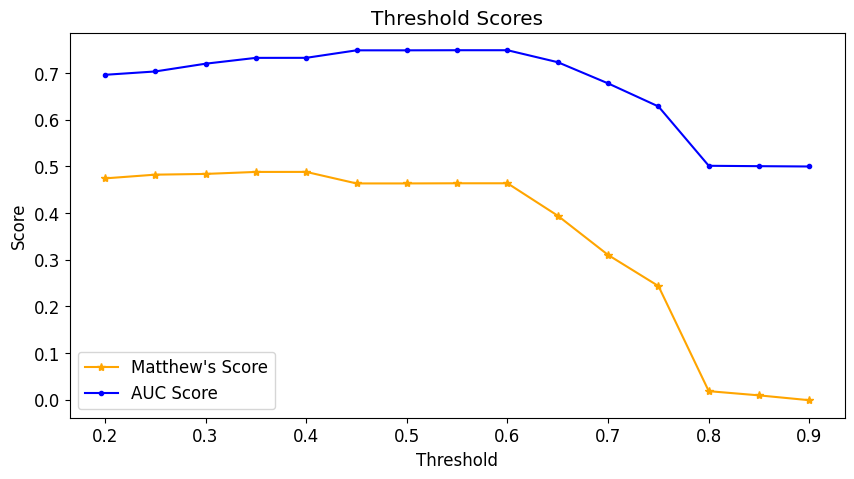

In [22]:
plot_threshold_scores(rf_cross_prob, rf_cross_test)

In [31]:
_ = change_threshold(rf_cross_prob, 
                     rf_cross_test, 
                     threshold = .64,
                     log = True)

Confusion Matrix: 
[[ 3575  1522]
 [ 3449 12023]]

ROC AUC Score: 0.7392370775821859
Matthews Correlation: 0.43561946098637516

Classification Report: 
              precision    recall  f1-score   support

        Died       0.51      0.70      0.59      5097
    Survived       0.89      0.78      0.83     15472

    accuracy                           0.76     20569
   macro avg       0.70      0.74      0.71     20569
weighted avg       0.79      0.76      0.77     20569



## ROC Plot

In [24]:
def plot_roc(pred_probs, y_test, threshold):
    # probs = [pd.DataFrame(a, columns = ['zero', 'one']) for a in pred_probs]
    # probs_final = pd.concat(probs)
    # probs_final = probs_final[['one']]
    probs_final = change_threshold(pred_probs, y_test, threshold = threshold)[4]
    y_test_master = pd.concat(y_test)
    
    fpr, tpr, _ = roc_curve(y_test_master,probs_final)
    auc = roc_auc_score(y_test_master,probs_final)
    plt.figure(figsize=(10,10))
    plt.plot(fpr,tpr,label=" auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

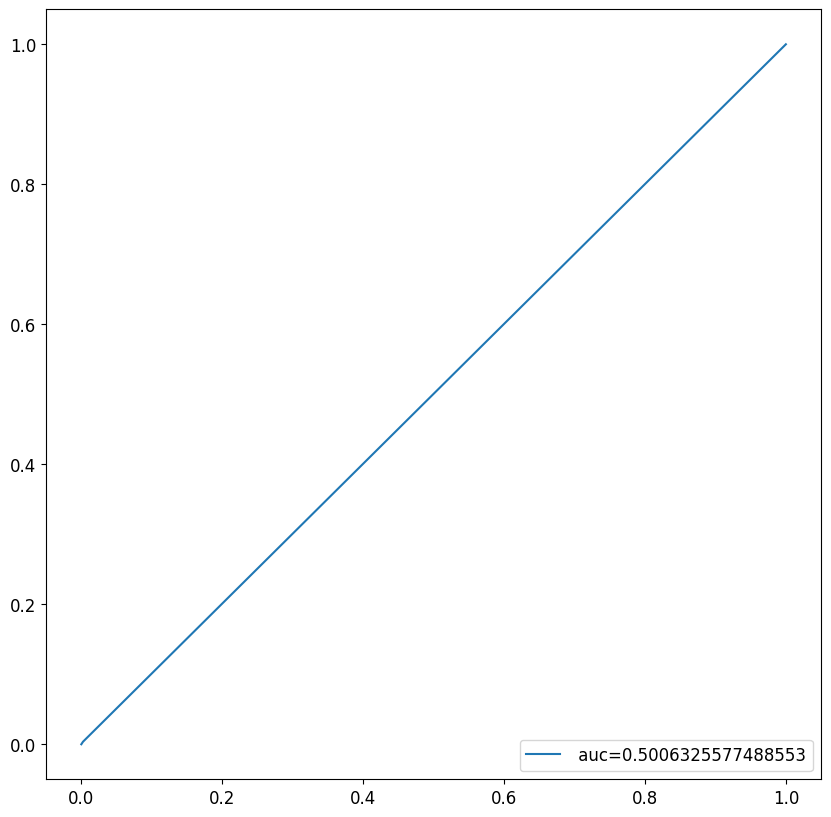

In [25]:
plot_roc(rf_cross_prob, rf_cross_test, 0.85)

# Feature Importance

In [26]:
# for gini importance
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

In [27]:
def row_to_dict(x,y=None):
    return X.apply(dict,axis=1)
    
def plot_importance(X, y, model, rot = 75, figsize = (20,5), kind = "bar"):
    ft = FunctionTransformer(row_to_dict, validate=False)
    dv = DictVectorizer()

    pipe = make_pipeline(ft,dv,model)
    pipe.fit(X,y)
    feature_importances = zip(dv.feature_names_,model[0].feature_importances_)
    
    feats = {}
    for feature, importance in zip(dv.feature_names_,feature_importances):
        feats[feature] = importance
        
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={1: 'Gini-importance'})
    importances.sort_values(by='Gini-importance').plot(kind=kind, rot=rot, figsize = figsize, fontsize=16)

In [28]:
rf_model[0].feature_importances_

array([0.01823394, 0.76438822, 0.07458251, 0.03727224, 0.1055231 ])

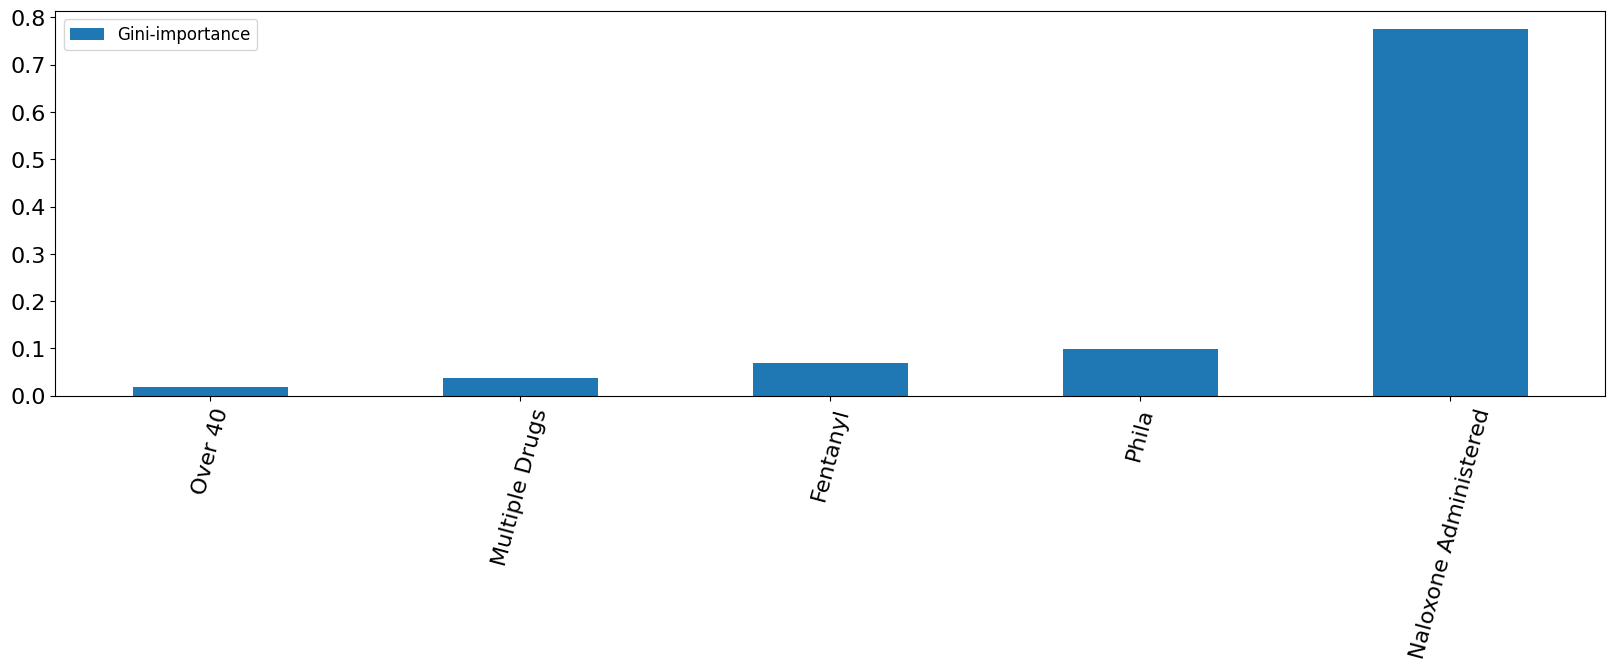

In [29]:
plot_importance(X, y, rf_model, rot = 75, figsize = (20,5))

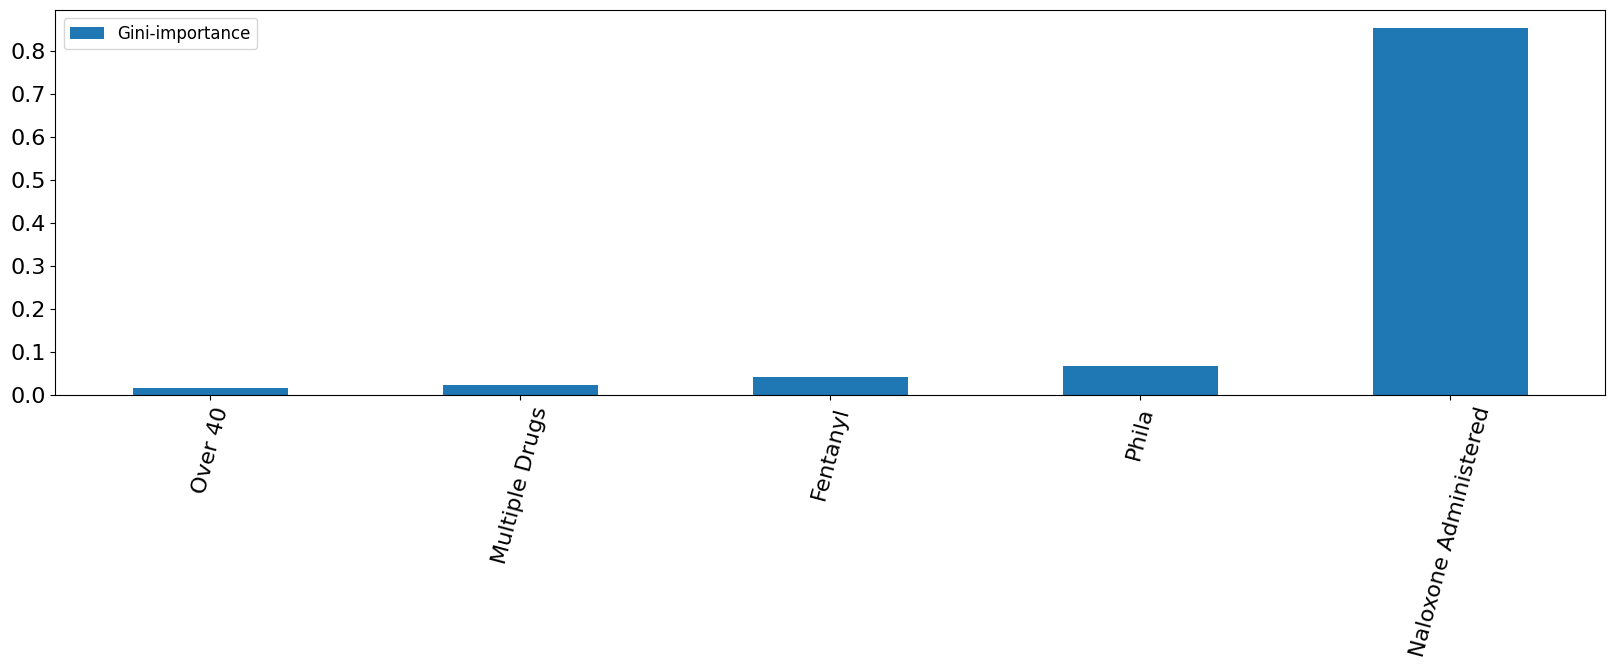

In [30]:
plot_importance(X, y, dt_model, rot = 75, figsize = (20,5))